# Star Formation in Galaxies

[Chris Richardson, Elon University](https://facstaff.elon.edu/crichardson17/) 

<i>Funding for this tutorial made possible through the [CATL Scholars Program](https://www.elon.edu/u/academics/catl/sotl/catl-scholars-program/)</i>

<i>This tutorial is intended for students to complete in groups. A version with solutions is available to instructors upon <a href="mailto:crichardson17@elon.edu">request</a>.</i>

## Objectives

- To explore scaling relationships among star forming galaxies in SDSS
- To understand how SDSS galaxy images and spectra can help us understand star formation rate (SFR) metrics
- To make a connection between the current SFR of a galaxy and its star formation history
- To provide a foundation to explore your own questions about star formation in galaxies

## Learning Outcomes

By the end of this tutorial you should be able to:

- Use H$\alpha$ to find the star formation rate in SDSS galaxies
- Use the star forming main sequence to identify starburst galaxies and quiescent galaxies
- Use SDSS image cutouts to explain bias in SFR metrics 
- Use D4000 as a proxy for star formation history

## Prerequisites

- Computational
    - Basic Python skills (e.g., for loops, conditional statements, defining functions)
    - Basics of <code>matplotlib</code> visualization, SQL queries, and SciServer platform (e.g., see [here](https://escip.io/notebooks/sdss_tutorial_1.html))
    - Using the <code>[astropy](https://docs.astropy.org/en/stable/units/index.html)</code> package for fundamental constants and unit conversion

- Astrophysics
    - Introductory knowledge of [galaxy classification](https://www.britannica.com/science/galaxy/Types-of-galaxies)
    - Introductory understanding of [stellar lifetimes and the HR diagram](https://openstax.org/books/astronomy/pages/22-1-evolution-from-the-main-sequence-to-red-giants)
    - Advanced conceptual understanding of applying the Case B approximation to counting photons

In [16]:
# Import relevant libraries

import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SkyServer as SkyServer # look up objects and generate images
import pandas as pd # data analysis 
import numpy as np # more data analysis
from matplotlib import pyplot as plt # another plotting library
from astropy.constants import c # useful constants
from astropy import units as u # useful for unit conversions
import astroML # enables plotting sdss spectrum
from astroML.datasets import fetch_sdss_spectrum
from astropy.io import ascii

In [4]:
# Make notebook have a clean appearance

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# Choosing a Sample of Galaxies

Several SDSS schema will be used in this tutorial, each with unique data products helpful to investigate star formation. The [<code>SpecObj</code>](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+galSpecLine+U) schema contains basic information about the observation and the object, such as the redshift $z$. The [<code>galaxy</code>](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+PhotoObjAll+U) schema provides useful photometric measurements for colors and images. The three <code>GalSpec</code> schema each give products derived from spectroscopy. As you should know, the H$\alpha$ emission line is a convienient indicator of the star formation rate. We want galaxies with quality measurements of this line strength, so a S/N restriction is specified. We also want the H$\beta$ emission line, because as we will see below, this will assist us in accounting for dust absorption along our line of sight.

- By using H$\alpha$ as indicator of star formation, how does this limit your analysis?
- How do you expect highly star forming galaxies to look?

<b>Your answers to these questions:</b>
<br>
<br>
<br>
<br>
<br>

In [5]:
# Create a query to fetch star forming galaxies

query = 'SELECT TOP 10000 s.plate, s.fiberid, s.mjd, s.ra, s.dec, s.z, s.zwarning, '
query += 'g.h_beta_flux, g.h_alpha_flux, '
query += 'g.h_beta_flux_err, g.h_alpha_flux_err, '
query += 'e.bptclass, e.lgm_tot_p50, '
query += 'i.lick_hd_a_sub, i.d4000_n_sub, '
query += 'i.lick_hd_a_sub_err, i.d4000_n_sub_err, '
query += 'p.petror90_r '
query += 'FROM GalSpecLine AS g, SpecObj AS s, GalSpecExtra AS e, GalSpecIndx AS i, galaxy AS p ' 
query += 'WHERE '
query += 's.specobjid = g.specobjid '
query += 'AND s.specobjid = e.specobjid '
query += 'AND s.specobjid = i.specobjid '
query += 'AND s.bestobjid = p.objid '
query += 'AND bptclass = 1 '
query += 'AND s.z BETWEEN 0.04 and 0.1 '#-- Lower limit needed for global parameters w/ small aperture
query += 'AND h_alpha_flux > h_alpha_flux_err*5.0 ' #-- Make sure Balmer lines have adequate S/N
query += 'AND h_beta_flux > h_beta_flux_err*5.0 '
query += 'AND d4000_n_sub > d4000_n_sub_err*5.0 '
query += 'AND h_alpha_flux_err > 0 ' #-- Consistency check
query += 'AND h_beta_flux_err > 0 '
query += 'AND h_alpha_flux > 2.7*h_beta_flux ' #-- Ensures proper continuum subtraction
query += 'AND lgm_tot_p50 > 0 '
query += 'AND sigma_balmer < 509.55 ' #-- Exclude the broad line emitting galaxies
query += 'AND s.class = \'GALAXY\' '  #-- Looking for galaxies, not stars
query += 'AND s.zwarning = 0 '
#print (query) # useful for debugging, remove first # to uncomment

# send query to CasJobs
gals = CasJobs.executeQuery(query, "dr16")

gals

,plate,fiberid,mjd,ra,dec,z,zwarning,h_beta_flux,h_alpha_flux,h_beta_flux_err,h_alpha_flux_err,bptclass,lgm_tot_p50,lick_hd_a_sub,d4000_n_sub,lick_hd_a_sub_err,d4000_n_sub_err,petror90_r
0,329,6,52056,177.62908,-3.326442,0.078031,0,45.879730,273.12190,3.291739,4.542729,1,10.661870,3.828772,1.453698,1.001100,0.028119,6.909836
1,326,147,52375,172.07771,-2.878846,0.095268,0,257.521400,785.83600,4.412366,7.641911,1,9.859731,7.313367,1.139154,1.037312,0.020886,6.646070
2,335,190,52000,189.26213,-2.982288,0.088555,0,54.240750,203.45360,2.292731,3.075485,1,9.830482,6.429802,1.246805,1.304015,0.028645,4.525309
3,337,27,51997,194.14905,-2.919338,0.052390,0,59.298840,234.12340,2.860254,3.917636,1,10.147940,4.229728,1.323284,1.003340,0.024767,6.746436
4,330,316,52370,176.92980,-2.563193,0.076802,0,112.538500,510.88790,3.626529,6.436479,1,10.251690,4.821437,1.284835,1.115302,0.026129,4.442664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1719,586,53876,229.20211,9.636919,0.085698,0,41.080730,162.25520,2.143597,2.654202,1,9.889796,4.391088,1.267068,1.423546,0.032088,6.319391
9996,1798,499,53851,199.25717,9.936388,0.052416,0,27.837730,209.10180,1.961622,3.422518,1,10.730490,0.963644,1.536464,1.222649,0.036792,7.227845
9997,1806,586,53559,208.88008,9.501891,0.070048,0,9.401968,40.19081,1.542465,1.394677,1,9.787393,1.583487,1.501869,1.816120,0.050408,10.510790
9998,1809,616,53792,212.79641,9.220711,0.079386,0,41.077510,190.89150,1.806039,2.547210,1,10.244090,5.054030,1.380123,1.052414,0.027612,4.488715


# Dereddening the Spectrum

In order to determine the star formation rate (SFR) in each galaxy, we need to get the H$\alpha$ luminosity $L$(H$\alpha$) emitted from each galaxy. The SQL query gives us the observed flux $F$(H$\alpha$), but this doesn't account for [dust](https://en.wikipedia.org/wiki/Cosmic_dust) absorbing some of this light as it travels from a galaxy to the point of observation. Fortunately, we can correct for this "extinction" by making use of the fact that dust preferentially absorbs shorter wavelength light to "deredden" the spectrum. In ideal conditions without dust, we can assume that $F$(H$\alpha$)/$F$(H$\beta$) = 2.86 in star forming regions. Let's deredden the H$\alpha$ flux.

In [6]:
# Deredden emission lines according to Calzetii+ 2000
# wavelength supplied in angstroms

def deredden(lum,wl,Hb,Ha):
    if (wl >= 6300 and wl <= 22000):
        wl = wl/1e4 # convert to microns
        kwl = 2.659*(-1.857+1.040/wl)+4.05
    elif (wl >= 1200 and wl < 6300):
        wl = wl/1e4 # convert to microns
        kwl = 2.659*(-2.156+1.509/wl-0.198/wl**2+0.011/wl**3)+4.05
    else:
        print ('Wavelength of range')
    
    # Using k-values calc as above
    kHa = 3.326
    kHb = 4.598
    
    ebmv = 2.5/(kHb-kHa)*np.log10(Ha/Hb/2.86) # 2.86 for SF; 3.1 for AGN
    lum_dr = lum*10**(0.4*kwl*ebmv)
    
    return lum_dr

####

Halpha_flux = gals['h_alpha_flux']
Hbeta_flux = gals['h_beta_flux']

Halpha_flux_dr = deredden(Halpha_flux,6563,Hbeta_flux,Halpha_flux)

# Determining the Star Formation Rate

According to the [<code>GalSpecLine</code>](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+galSpecLine+U) schema, the line flux is returned as 10$^{-17}$ <i>erg/s/cm$^2$</i>, so we first need to multiply our dereddened $F$(H$\alpha$) by 10$^{-17}$ to get actual flux value. Luminosity has units of energy / second, and an <i>erg</i> is a unit of energy, so we're almost there. Use the space provided below to convert $F$(H$\alpha$) to $L$(H$\alpha$) and name that variable <code>Halpha_lum_dr</code>.

- How can you get the distance to the galaxy in <i>cm</i>?
- How does distance factor into converting flux to luminosity?

In [7]:
# your code for calculating Halpha_lum_dr

# Halpha_lum_dr = 

We can now use the $L$(H$\alpha$) to determine the SFR in units of M$_{\odot}$/yr using the conversion from [Kennicutt+ 1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...498..541K/abstract).

In [8]:
sfr = np.log10(Halpha_lum_dr*7.9e-42)

gals['sfr'] = sfr

plt.hist(sfr,bins=20)

plt.xlim(-2.5,2.0)

plt.xlabel(r'SFR [M$_{\odot}$/yr]')
plt.ylabel('N')

plt.show()

NameError: name 'Halpha_lum_dr' is not defined

# The Star Forming Main Sequence

A common measure of galaxy mass is its stellar mass M$_*$ in units of M$_{\odot}$, however a galaxy's mass can be defined in many ways. We can roughly envision that M$_*$ is proxy for galaxy size since larger galaxies typically contain more stars.

- Would you expect the number of star froming regions in a galaxy to increase or decrease as M$_*$ increases?
- How would expect the SFR to correlate with M$_*$? Explain.

<b>Your answers to these questions:</b>
<br>
<br>
<br>
<br>
<br>

NameError: name 'Mstar' is not defined

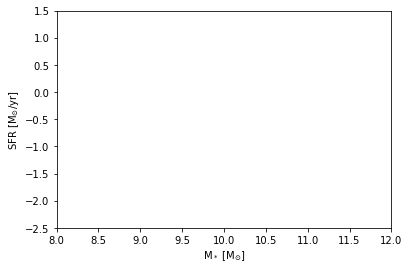

In [9]:
#Mstar = gals['lgm_tot_p50'] #uncomment this line

mstar_array = np.linspace(8.0,12.0,100)
poly1d_fn = np.poly1d([1.192,-12.31])

plt.xlabel(r'M$_*$ [M$_{\odot}$]')
plt.ylabel(r'SFR [M$_{\odot}$/yr]')

plt.xlim(8.0,12.0)
plt.ylim(-2.5,1.5)

plt.scatter(Mstar,sfr,s=0.5)
plt.plot(mstar_array, poly1d_fn(mstar_array), 'k--',label='MS')

plt.legend(loc='lower right')

We can see that star forming galaxies lie on what is known as the star forming main sequence, which is a shout out to the stellar main sequence on the HR diagram. The SF main sequence is based on the correlation between SFR and M$_*$ where "typical" star forming galaxies lie.

- In terms of appearance, how would you expect SF galaxies with high SFR to compare to those with low SFR?
    - Would you expect them to be spirals or elliptical? 
    - Blue in color or red in color?
    - Brighter or dimmer?

<b>Your answer to this question:</b>
<br>
<br>
<br>
<br>
<br>

# Visualizing the Sample with Image Cutouts

Once you have provided your answer above, let's actually have a look at the images of galaxies that have high SFR and low SFR. We can create function to gather up the images for us. The function takes in an filtered array of galaxies to isolate those of interest and description of the filtering procedure to display at run time. The first block of code will display the high SFR rate galaxies and then next block will display low SFR galaxies.

In [ ]:
#
# Function to display images
#
def get_images(gal_array,description):
    # set thumbnail parameters
    width=200           # image width
    height=200          # height
    pixelsize=0.396     # image scale
    plt.figure(figsize=(15, 15))   # display in a 4x4 grid
    subPlotNum = 1

    i = 0
    new_gals = gal_array
    nGalaxies = len(new_gals)
    for index,new_gals in new_gals.iterrows():           # iterate through rows in the DataFrame
        i = i + 1
        if i<17:
            print('Getting image of '+description+str(i)+' of '+str(nGalaxies)+'...')
            if (i == nGalaxies):
                print('Plotting images...')
            scale=new_gals['petror90_r']/pixelsize/width
            img= SkyServer.getJpegImgCutout(ra=new_gals['ra'], dec=new_gals['dec'], width=width, height=height, scale=scale, dataRelease='DR16')
            plt.subplot(4,4,subPlotNum)
            subPlotNum += 1
            plt.imshow(img)                               # show images in grid
            plt.title(index)
            
######

filtered_gals = gals[(gals['sfr']> -0.05) & (gals['sfr']< 0.05)] # only galaxies with high SFR
get_images(filtered_gals,'high SFR galaxy ') # call function with filtered galaxy array


In [ ]:
filtered_gals = gals[(gals['sfr']> -1.55) & (gals['sfr']< -1.45)] # only galaxies with high SFR
get_images(filtered_gals,'low SFR galaxy ')

How did these results compare to your answer above?

It might seems intuitive to think that a high SFR means that more O- and B-type stars, which means blue colors in disk-like structures. However, while it's true that most of the images above are disk-like, there's a wide assortment of colors. In fact, there's a variety colors and disk-like structures in both samples, suggesting that they have something in common (i.e., the MS).

Much like stars can deviate from the MS on the HR diagram, galaxies can deviate from the MS on the SFR-M$_*$ diagram. At a given M$_*$, starburst galaxies have 10x the SFR of MS galaxies, while quiescent galaxies have a 0.01x the SFR of MS galaxies. Use these definitions to add two more lines to the SFR-M$_*$ plot denoting the location of starbursts and quiescent galaxies.

In [10]:
# your code to add starburst and quiescent demarcations

# Understanding the sSFR Metric

It becomes evident from this plot that when we want to identify a highly star forming galaxy, the metric we're usually after is the specific star formation rate sSFR. It is defined as

$\mathrm{sSFR}\equiv\frac{\mathrm{SFR}}{\mathrm{M}_*}$

and represents ratio of current star formation to past star formation, or the growth rate of stellar mass in a galaxy. We can add the sSFR to our dataframe to explore the metric in detail.

In [ ]:
ssfr = np.log10(10**sfr/10**Mstar)
gals['sSFR'] = ssfr

plt.xlim(-12,-8)

plt.xlabel(r'sSFR [yr$^{-1}$]')
plt.ylabel('N')

plt.hist(gals['sSFR'],bins=25)
plt.show()

In the cell below, display the images for a sample of starburst galaxies and a sample of quiescent galaxies. Do these galaxies align with what you orignally envisioned high and low SFR galaxies to look like?

In [ ]:
# your code to display images of starburst and quiescent

While the sSFR is measure of the relative star formation taking place in a galaxy, the sSFR values aren't that intuitive. A simple way to gain more intuition is by taking the inverse of the sSFR, which gives us

$\tau_d = \frac{\mathrm{M}_*}{\mathrm{SFR}}$

where $\tau_d$ is the amount of time needed to form the current stellar population or the mass-doubling timescale. We can infer the SFHs of galaxies by comparing $\tau_d$ to the Hubble time (i.e., the age of the universe). In the space below, compare the mass-doubling timescales of the galaxies to the Hubble time.

In [11]:
# your code to calculate doubling times and compare to the Hubble time

- Which galaxies formed most of their stars long ago and which galaxies are forming most of their stars now?
- Where do these galaxies fall relative to the SF main sequence?
- How do the masses of these galaxies compare?

<b>Your answers to these questions:</b>
<br>
<br>
<br>
<br>
<br>

# Creating a Link to SFHs

We can use $\tau_d$ to infer the star formation history (SFH) of a galaxy, but underlying blackbody curve in the continuum of galaxies also tells us about their SFH. The “break” at 400 nm (4000 Angstroms) is typically written as D4000 and serves as a measure for the discontinuity of the blackbody curve. It is typically defined as,

$D4000 = \frac{\int_{4000}^{4100}f_{\lambda} d\lambda}{\int_{3850}^{3950}f_{\lambda} d\lambda}$


where the integration over wavelength is shown in Angstroms. Under this definition, D4000 = 1.0 would represent a flat underlying spectrum, also known as the continuum. If D4000 > 1.0 then there's a discontinuity in the continuum. Let's take a look at the spectrum around 4000 Angstroms for starburst galaxy and a quiescent galaxy.

In [ ]:
starbursts = gals[gals['sSFR']>-9.5]
indices = starbursts.index.values
plate = starbursts['plate'][indices[0]]
mjd = starbursts['mjd'][indices[0]]
fiber = starbursts['fiberid'][indices[0]]

spec = fetch_sdss_spectrum(plate=plate,fiber=fiber,mjd=mjd)

ax = plt.axes()
plt.xlim(3800,4300)
plt.ylim(0,30)
plt.xlabel('$\lambda$')
plt.ylabel('$F_{\lambda}$')
ax.plot(spec.wavelength(), spec.spectrum, '-k', label='spectrum')

In [ ]:
quiescent = gals[gals['sSFR']<-11.5]
indices = quiescent.index.values
plate = quiescent['plate'][indices[1]]
mjd = quiescent['mjd'][indices[1]]
fiber = quiescent['fiberid'][indices[1]]

spec = fetch_sdss_spectrum(plate=plate,fiber=fiber,mjd=mjd)

ax = plt.axes()
plt.xlim(3800,4500)
plt.ylim(0,30)
plt.xlabel('$\lambda$')
plt.ylabel('$F_{\lambda}$')
ax.plot(spec.wavelength(), spec.spectrum, '-k', label='spectrum')

- Do these plots make sense to you given what you know about D4000, starburst galaxies, and quiescent galaxies? Explain.
- In the space below, explain how you would expect D4000 to correlate with sSFR.
- Write a snippet of code to verify your answer.

<b>Your answer to this question:</b>
<br>
<br>
<br>
<br>
<br>

In [12]:
# your plot showing the correlation between sSFR and D4000

# Follow Up Questions

In this Lecture-Tutorial, we developed some intuition about star formation in galaxies. There are several avenues for further exploration that you can dig into further.

- Construct a color magnitude diagram of the galaxies in our sample
    - Where do the low mass and high mass galaxies lie?
    - Are there trends with MS / starbursting / quiescent galaxies?
    - How would you expect D4000 to correlate with g-r color?